# **Task 2: Model Training**

In [ ]:
import torch
import torch.nn as nn
from transformers import LlamaForCausalLM, LlamaConfig, AutoTokenizer
import pandas as pd

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


# **Choosing the best tokenizer trained from Task 1**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/task2-files/tokenizer_5')

# **Adjusting the model architecture in such a way that its total parameters are less than 100M. (25 Pts)**

In [ ]:
config = LlamaConfig( hidden_size=256,
                     vocab_size=len(tokenizer.vocab),
                     num_attention_heads=4,
                     num_key_value_heads=1,
                     num_hidden_layers=8,
                     intermediate_size=512 )

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LlamaForCausalLM(config).to(device)

# Xavier initialization
for name, param in model.named_parameters():
    if param.requires_grad and param.dim() > 1:
        nn.init.xavier_uniform_(param)


In [ ]:
df = pd.read_csv('/kaggle/input/task2-files/combined_output_part5.csv', usecols=[1], header=None, dtype={1: str})
df.columns = ['text']
df.fillna('', inplace=True)

input_ids = tokenizer(df['text'].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")["input_ids"]


In [ ]:

train_data = torch.utils.data.TensorDataset(input_ids)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)


learning_rate = 5e-5
epochs = 1
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad and len(param.size()) > 1:
        nn.init.xavier_uniform_(param.data)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params / 1e6}M")

Total Parameters: 20.845312M


# **As shown above, our model had 20.84M parameters.**

In [ ]:
batch_size = 8
learning_rate = 5e-5
epochs = 1
perplexity_values = []

# **Model training is done below, perplexity is also printed every 0.1 epoch**

In [ ]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    num_batches = len(train_loader)

    for batch_num, batch in enumerate(train_loader):
        inputs = batch[0].to(device)

        outputs = model(inputs, labels=inputs)
        loss = outputs.loss
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log perplexity at every 0.1 epoch
        if batch_num % (num_batches // 10) == 0:
            perplexity = torch.exp(torch.tensor(epoch_loss / (batch_num + 1)))
            print(f"Perplexity at {epoch + (batch_num / num_batches):.1f} epoch: {perplexity.item()}")

Perplexity at 0.0 epoch: 32350.666015625
Perplexity at 0.1 epoch: 1584.27734375
Perplexity at 0.2 epoch: 684.3477783203125
Perplexity at 0.3 epoch: 438.08929443359375
Perplexity at 0.4 epoch: 319.1033020019531
Perplexity at 0.5 epoch: 256.9993896484375
Perplexity at 0.6 epoch: 213.5207977294922
Perplexity at 0.7 epoch: 185.11898803710938
Perplexity at 0.8 epoch: 163.6551055908203


KeyboardInterrupt: 

# **In the above model training cell, we interupted the kernal at 0.9 epoch instead of allowing it to train till 1.0 epoch because we were running short on runtime and since we had to save and download the model, also to prepare perplexity matrix and to get responses from the prompts using the model, we stopped the training at 0.9 epoch (instead of 1.0).**

In [ ]:
torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
print(f"Model saved at model_epoch_{epoch + 1}.pth")

Model saved at model_epoch_1.pth


In [ ]:
from IPython.display import FileLink
FileLink(r'model_epoch_1.pth')

/kaggle/working/model_epoch_1.pth

# **Below is the matrix/graph of Perplexity with epoch values (range of 0.1 to 0.9)**

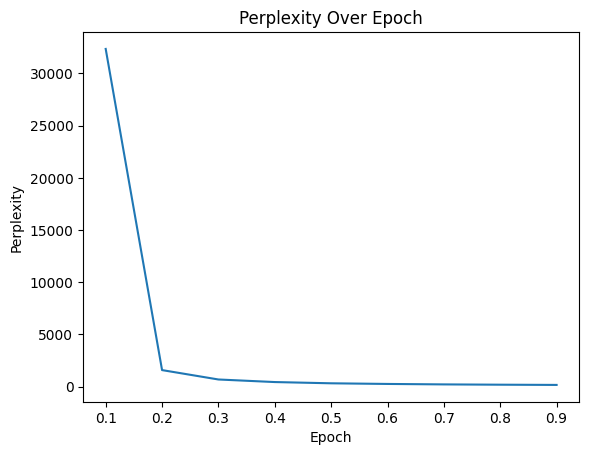

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the perplexity values and corresponding epochs
perplexity_values = [
    32350.666015625,
    1584.27734375,
    684.3477783203125,
    438.08929443359375,
    319.1033020019531,
    256.9993896484375,
    213.5207977294922,
    185.11898803710938,
    163.6551055908203
]

# Convert to a numpy array
perplexity_matrix = np.array(perplexity_values)

# Define x-axis values from 0.1 to 0.9 with a step of 0.1
epochs = np.arange(0.1, 1.0, 0.1)

# Plot the graph
plt.plot(epochs, perplexity_matrix)
plt.title('Perplexity Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')

# Show the plot
plt.show()


In [ ]:
prompts = [
    "Wie sieht ein typischer Tag in deiner Stadt aus?",
    "Was sind die Vorteile der Nutzung erneuerbarer Energien?",
    "Erzähle mir von einem Buch, das du kürzlich gelesen hast.",
    "Was sind die größten Herausforderungen bei der Arbeit im Homeoffice?",
    "Wie funktioniert der Prozess der Photosynthese in Pflanzen?",
    "Was ist der Unterschied zwischen Demokratie und Diktatur?",
    "Welche Rolle spielt Technologie in der heutigen Bildung?",
    "Was sind die wichtigsten Eigenschaften eines guten Führers?",
    "Erkläre den Begriff 'Künstliche Intelligenz' in einfachen Worten.",
    "Was sind die Vorteile von gesunder Ernährung und regelmäßiger Bewegung?"
]


In [ ]:
i=0
for prompt in prompts:
    print(f"Prompt_{i+1}: {prompt}")


    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)


    with torch.no_grad():
        outputs = model.generate(input_ids, attention_mask=attention_mask,
                                 max_length=100, num_return_sequences=1,
                                 pad_token_id=tokenizer.eos_token_id,
                                 temperature=0.7, top_p=0.9,
                                 repetition_penalty=1.2,do_sample=True)


    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Response_{i+1}: {response}")
    print('\n')
    i+=1


Prompt_1: Wie sieht ein typischer Tag in deiner Stadt aus?
Response_1: Wie sieht ein typischer Tag in deiner Stadt aus?en und der Putette Kulch in den Ram ( ) und "arel" von Gumed" hat die beiden Tochter von ihrem TV.  ) nach dem Lrozeny Corida ( ),  -Jährige als  Jahre über seine  . Jahre im Jahr  -Jährige


Prompt_2: Was sind die Vorteile der Nutzung erneuerbarer Energien?
Response_2: Was sind die Vorteile der Nutzung erneuerbarer Energien? Wir verraten dir, ist das mal ein einem Bur und wie du die Haarste Kind zu finden. Das ist die Haut in einer Kunern für  Euro - und es kannst du dich im Sternzeichen viel schehen. Die Vorzeiten ist sich von ihrem Anden Teit. Der besten Menschen gibt es auf die Haut mit dem Zeit zum Trenden. Im Video erfährst du hier dir: 
Ochte! Und das kann aus dem Körper


Prompt_3: Erzähle mir von einem Buch, das du kürzlich gelesen hast.
Response_3: Erzähle mir von einem Buch, das du kürzlich gelesen hast.Seine  . - bis  .“ mit dem beiden Ha I of Boy" hat es e

# **In the above output cell, we can see the responses generated by the model for the given 10 prompts.**